### <center><font> Tutorial #3 Computer- and robot-assisted surgery</font></center>
## <center><font> Tomography II</font></center>
<center>&copy; Sebastian Bodenstedt, National Center for Tumor Diseases (NCT) Dresden<br>
    <a href="https://www.nct-dresden.de/"></a> </center>

## <center><font color=navy>Preperation</font></center>

For this tutorial, we will utilize the OpenCV, Matplotlib and NumPy:

In [2]:
import cv2
import numpy as np
# Force Matplotlib to display data directly in Jupyter
%matplotlib inline 
from matplotlib import pyplot as plt
import scipy.interpolate
from scipy import ndimage
import math

We will also download and extract a few image sequences:

In [3]:
import urllib.request
from os.path import basename, exists
import zipfile

def download_and_extract(url): #download and extract Zip archive
    file_path = basename(url)
    if not exists(file_path): # does zip file already exist?
        urllib.request.urlretrieve(url, file_path) # if not, download it
        with zipfile.ZipFile(file_path, 'r') as zip_ref: # and unzip it
            zip_ref.extractall(".")

In [4]:
download_and_extract("http://tso.ukdd.de/crs/Exercise3.zip") # In case you didn't download the data last week

We now list the extracted files:

In [5]:
!ls *

Exercise1.zip     README.md         Tutorial_02.ipynb
Exercise3.zip     Tutorial_01.ipynb Tutorial_03.ipynb

Exercise1:
ct1.png        img_01_raw.png img_04_raw.png img_07_raw.png img_10_raw.png
ct2.png        img_02_raw.png img_05_raw.png img_08_raw.png
ct3.png        img_03_raw.png img_06_raw.png img_09_raw.png

Exercise3:
Example.jpg    img_01_raw.png maulwurf.jpg

slides:
UB_CRC_WS24_02.pdf VL_CRC_WS24_02.pdf


## <center><font color=navy>Basic functions</font></center>
We define a function for displaying grayscale images

In [6]:
def show_gray(img, canvas=plt, title=""): # Later we want to draw on a different underground, so we define this as a parameter
    canvas.imshow(img, cmap='gray', vmin=0, vmax=255)
    if not title == "":
        canvas.set_title(title)

## <center><font color=navy>Review image loading and rotation</font></center>
First, we develop a method to rotate 2D images:

(236, 236) (334, 334)


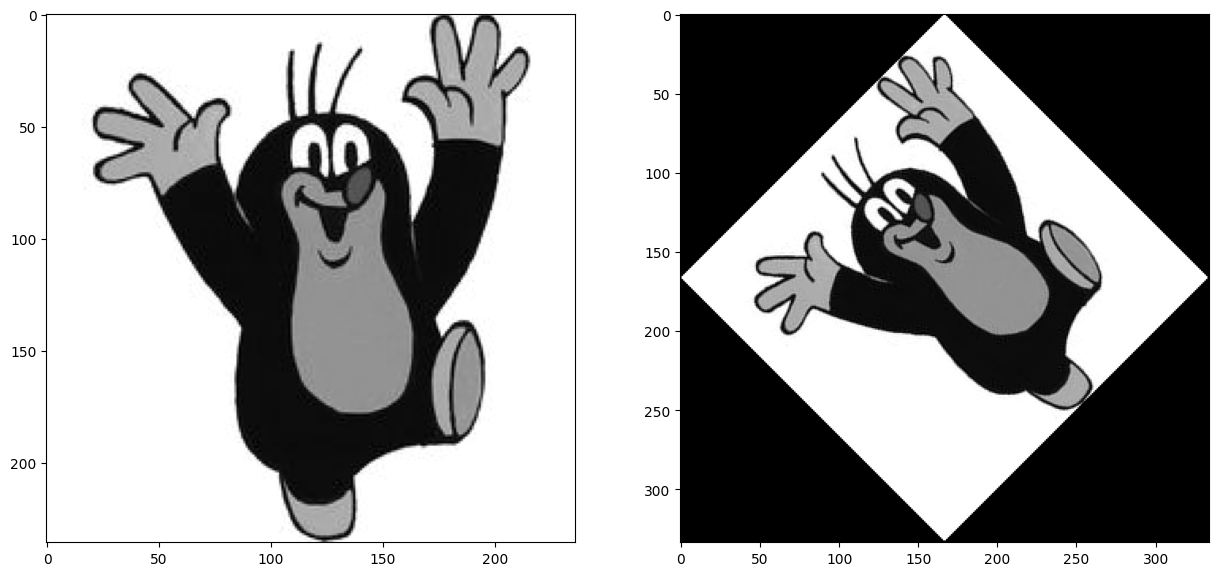

In [7]:
# Load image in grayscale
#img_gray = cv2.imread("Exercise2/Example.jpg", cv2.IMREAD_GRAYSCALE)
#img_gray = cv2.imread("Exercise3/img_01_raw.png", cv2.IMREAD_GRAYSCALE)
img_gray = cv2.imread("Exercise3/maulwurf.jpg", cv2.IMREAD_GRAYSCALE)

# Make sure image is square
size = min(img_gray.shape[0],img_gray.shape[1])
img_gray = img_gray[:size,:size]

figure, axis = plt.subplots(1, 2, figsize=(15, 15)) # subplots let you visualize multiple outputs simultanously

show_gray(img_gray, axis[0])

img_rot2 = ndimage.rotate(img_gray, 45)

show_gray(img_rot2, axis[1])
print(img_gray.shape, img_rot2.shape)

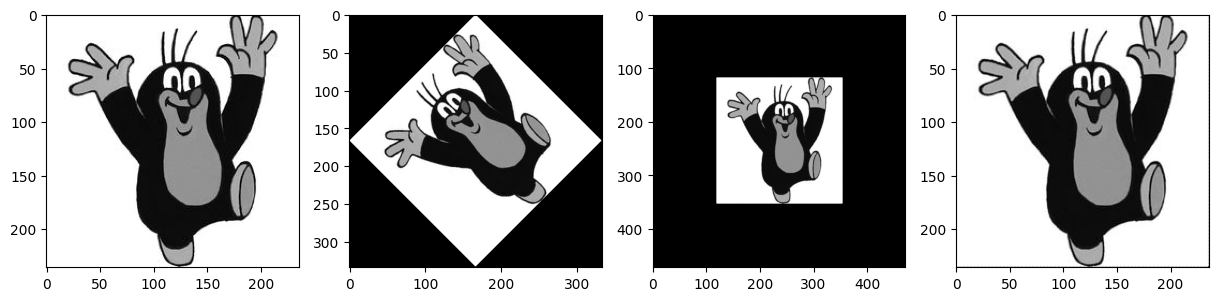

In [8]:
figure, axis = plt.subplots(1, 4, figsize=(15, 15)) # subplots let you visualize multiple outputs simultanously

show_gray(img_gray, axis[0])

shape = img_gray.shape

img_rot = ndimage.rotate(img_gray, 45)

show_gray(img_rot, axis[1])

img_rot_back = ndimage.rotate(img_rot, -45)

show_gray(img_rot_back, axis[2])

offset_y = (img_rot_back.shape[0] - shape[0])//2 # Find Center of image
offset_x = (img_rot_back.shape[1] - shape[1])//2
         
img_rot_back_crop = img_rot_back[offset_y:offset_y + shape[0],offset_x:offset_x + shape[0]] # Crop result and apply it to output
show_gray(img_rot_back_crop, axis[3])        

## <center><font color=navy>Fourier Transformation in NumPy</font></center>
Reminder, we can represent an image by the frequencies it contains, using the Fourier Transformation:

In [9]:
ft = np.fft.fft2(img_gray) # 2D fourier transform of our image
ft_centered = np.fft.fftshift(ft) # shift the transform, so the origin is in the center of the image

We can visualize the spectrum of the image

In [10]:
spec = np.log(abs(ft_centered))

And we can also reverse the Fourier Transform

In [11]:
ift = np.fft.ifftshift(ft_centered) # Reverse shift
ift = np.fft.ifft2(ift) # Inverse Fourier

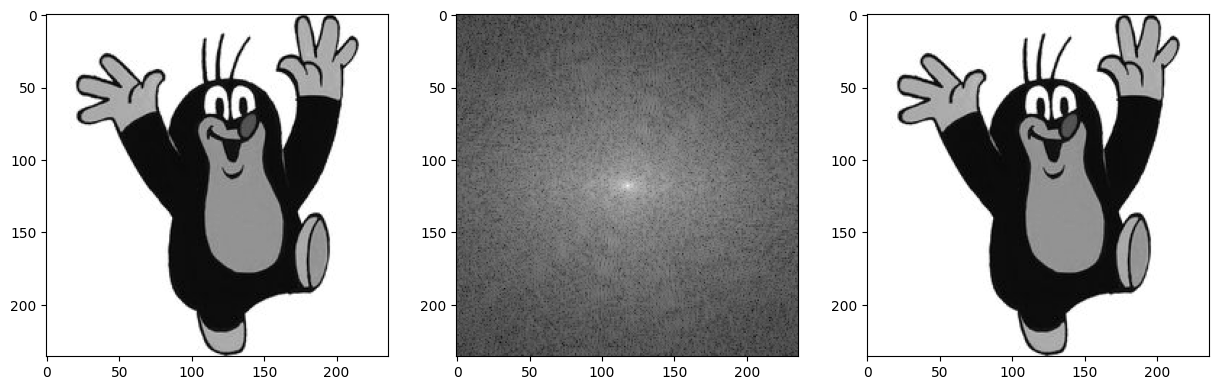

In [12]:
figure, axis = plt.subplots(1, 3, figsize=(15, 15)) # subplots let you visualize multiple outputs simultanously
axis[0].imshow(img_gray, cmap='gray')
axis[1].imshow(spec, cmap='gray')
axis[2].imshow(np.real(ift), cmap='gray')


You can modify the spectrum using image manipulation. One way is to create a mask and apply it to the spectrum:

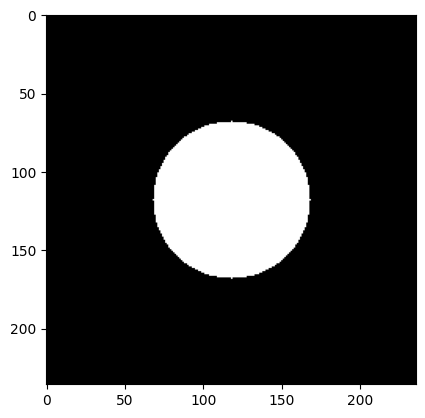

In [13]:
radius = 50

mask = np.zeros(ft_centered.shape, dtype=np.uint8) # Create an empty image
mask = cv2.circle(mask, (ft_centered.shape[0]//2, ft_centered.shape[0]//2), radius,1,-1) # Draw a circle
plt.imshow(mask, cmap='gray')

/var/folders/3f/vspzm0s56cv8d6_vgz15shf40000gn/T/ipykernel_49240/4005232369.py:4: RuntimeWarning: divide by zero encountered in log
  spec_mod = np.log(abs(ft_centered_mod))


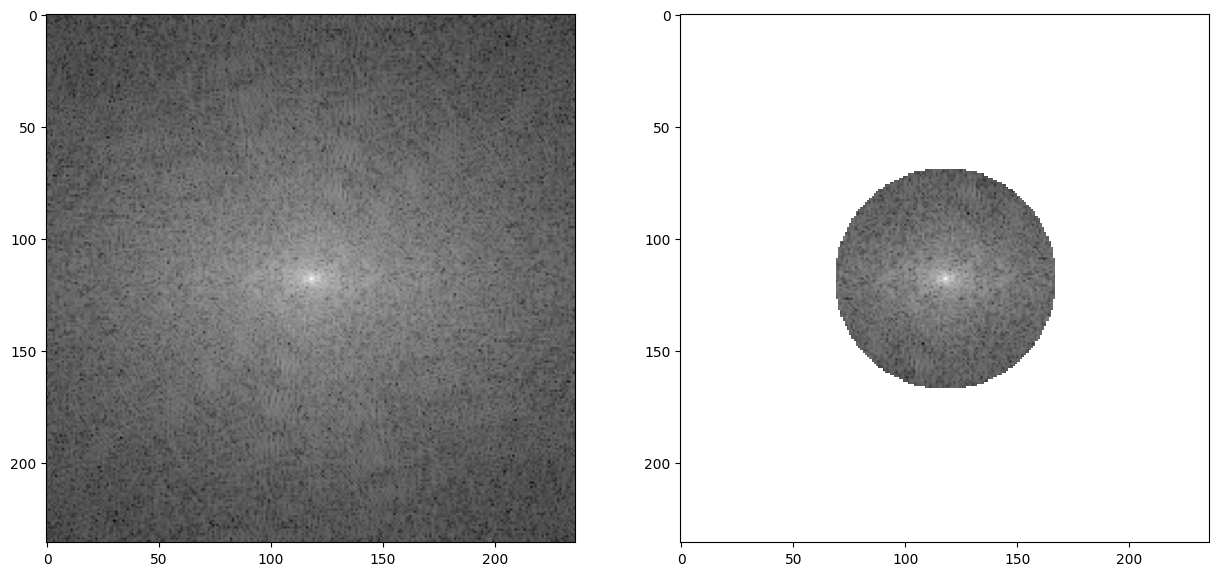

In [14]:
ft_centered_mod = ft_centered.copy()
ft_centered_mod[mask == 0] = 0 # set frequencies outside circle to 0

spec_mod = np.log(abs(ft_centered_mod))
figure, axis = plt.subplots(1, 2, figsize=(15, 15)) # subplots let you visualize multiple outputs simultanously
axis[0].imshow(spec, cmap='gray')
axis[1].imshow(spec_mod, cmap='gray')

-48.76689053914639 315.5056114390651 183.7173764722781


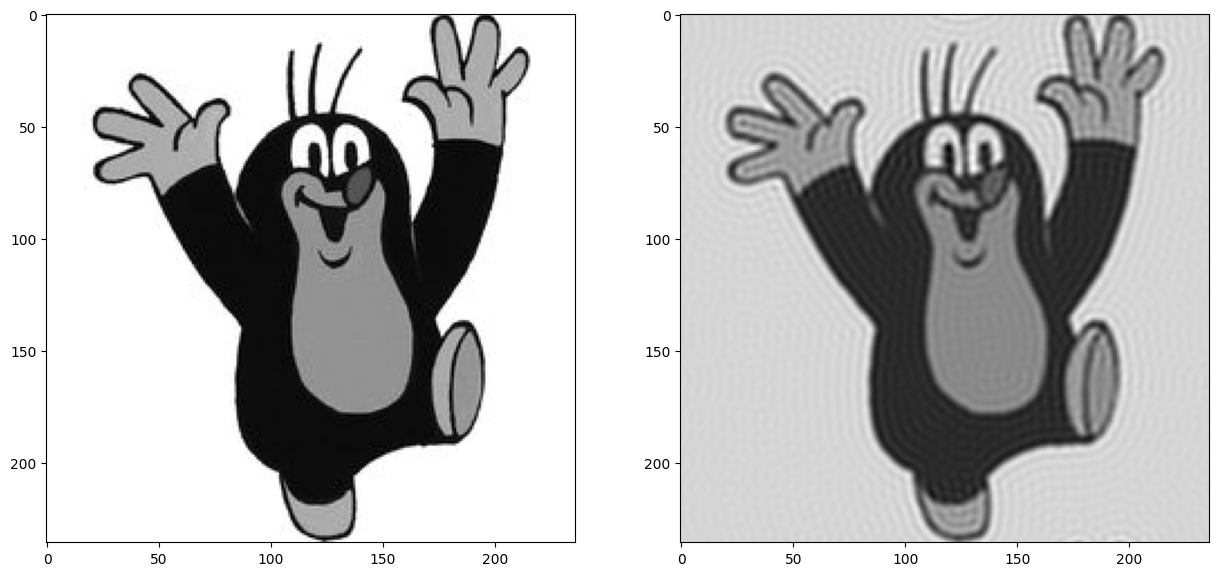

In [15]:
ift = np.fft.ifftshift(ft_centered_mod)
ift = np.fft.ifft2(ift)

figure, axis = plt.subplots(1, 2, figsize=(15, 15)) # subplots let you visualize multiple outputs simultanously
show_gray(img_gray, axis[0])
axis[1].imshow(np.real(ift), cmap='gray')
print(np.min(np.real(ift)), np.max(np.real(ift)), np.mean(np.real(ift)))

## <center><font color=navy>Simulated CT</font></center>

Next, we simulate the projection step of a CT:

In [16]:
def calc_proj(image, step_size):
    assert image.shape[0] == image.shape[1] # check if images are square
    num_steps = 180//step_size # Calculate the number of steps
    diag = round(math.sqrt(2*image.shape[0]*image.shape[0])) # calculate diagonal of the image, i.e. the maximum number of pixels when rotated 45 degrees
    print(diag)
    
    projections = np.zeros((num_steps, diag), dtype=np.float64) # Setup container for all projections
    
    count = 0
    for angle in range(0, 180, step_size):
        rot_image = ndimage.rotate(image, angle) # Rotate image
        proj = np.sum(rot_image, axis=0) # Calculate projection by adding values along axis 0
        
        projections[count, 0:rot_image.shape[0]] = proj # save projection
        count+=1
    
    return projections

In [17]:
degrees = 1 # Step size
projs = calc_proj(img_gray, degrees) # Calculate projections
shape = img_gray.shape
print(projs.shape)
data = {"projections" : projs, "shape" : shape, "step_size" : degrees}

334
(180, 334)


In [18]:
import pickle

pickle.dump( data, open( "Exercise3/output.pkl", "wb" ) ) #Save projections

## <center><font color=navy>Reconstruction with Fourier</font></center>
First, we load a mystery image encoded with the code above ;)

In [19]:
data = pickle.load( open( "Exercise3/output.pkl", "rb" ) ) # Load a secret

step_size = data["step_size"]
projs = data["projections"]
shape = data["shape"]

print(step_size)

1


Now, we will reconstruct the image using the Radon Transformation/Fourier Slice Theorem

In [22]:
def reconstruction(input_proj, step_size, output_shape):
    output = np.zeros(output_shape, dtype=np.complex64) # Output image
    mask = np.zeros(output_shape, dtype=np.int64)
    
    num_steps = 180//step_size
    
    count = 0
    for angle in range(0, 180, step_size):
        # rotate current image and mask to the right angle
        
        rot_mask = ndimage.rotate(mask, angle)
        rot_image = np.zeros(rot_mask.shape, dtype=complex) # Output image
        
        proj = input_proj[count, 0:rot_image.shape[0]]
        
        ft = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(proj)))#.reshape(1,-1)
        rot_image[rot_image.shape[0]//2] = ft
        
        ret = ndimage.rotate(rot_image, -angle) # rotate delta mask back 
  
        offset_y = (ret.shape[0] - output_shape[0])//2 # Find Center of image
        offset_x = (ret.shape[1] - output_shape[1])//2
         
        output += ret[offset_y:offset_y + output_shape[0],offset_x:offset_x + output_shape[0]] # Crop result and apply it to output
        
        count+=1
      
    return output

In [23]:
res = reconstruction(projs, step_size, shape)

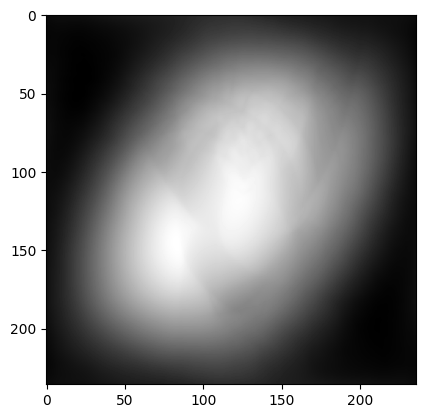

In [24]:
res2 = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(res))))

plt.imshow(res2, cmap='gray')

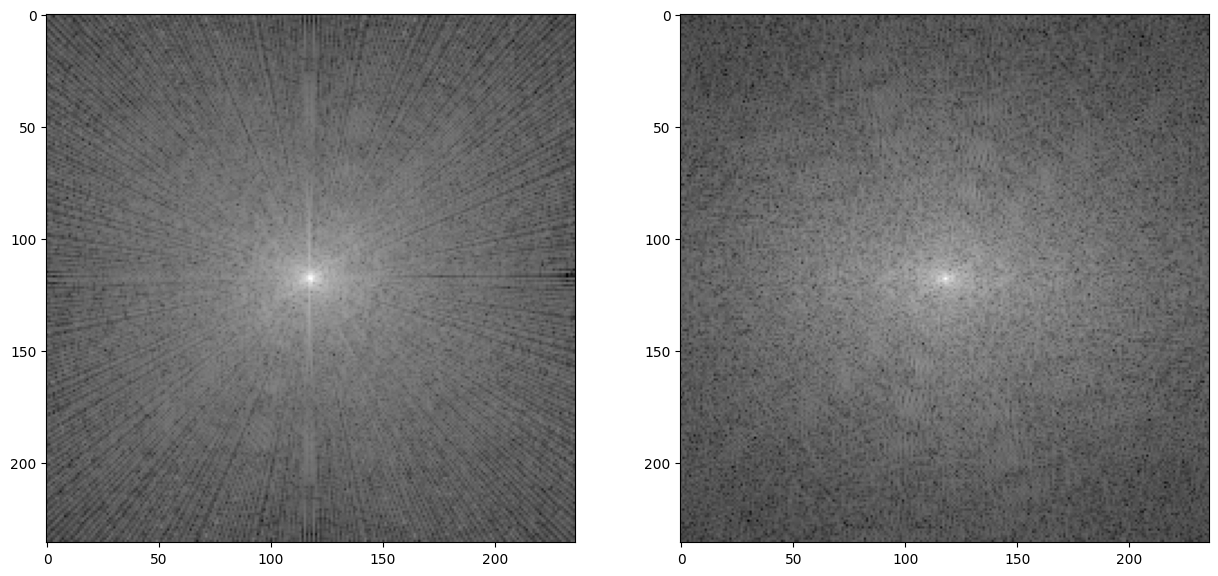

In [25]:
spec_mod = np.log(abs(res))
figure, axis = plt.subplots(1, 2, figsize=(15, 15)) # subplots let you visualize multiple outputs simultanously

axis[0].imshow(spec_mod, cmap='gray')
axis[1].imshow(spec, cmap='gray')

In [26]:
def reconstruction2(input_proj, step_size, output_shape):
    mask = np.ones(output_shape, dtype=np.int64)
    num_steps = 180//step_size
    
    count = 0
    src_x = []
    src_y = []
    
    vals = []
    
    des_x = []
    des_y = []
    for angle in range(0, 180, step_size):
        rot_mask = ndimage.rotate(mask, angle)
        a = angle*(math.pi/180.0)
        
        S = rot_mask.shape[0]
        r = ((np.arange(S) - S / 2)/S)*output_shape[0]
        
        srcx = (output_shape[0] / 2) + r * np.cos(a)
        srcy = (output_shape[0] / 2) + r * np.sin(a)
        
        src_x.append(srcx)
        src_y.append(srcy)
        
        proj = input_proj[count, 0:rot_mask.shape[0]]
        ft = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(proj)))
        
        vals.append(ft)
                
        count+=1
    
    src_x = np.concatenate(src_x)
    src_y = np.concatenate(src_y)
    vals = np.concatenate(vals)
    
    dstx, dsty = np.meshgrid(np.arange(output_shape[0]), np.arange(output_shape[0]))
    dstx = dstx.flatten()
    dsty = dsty.flatten()
    
    fft2 = scipy.interpolate.griddata(
    (src_x, src_y),
    vals,
    (dstx, dsty),
    method="linear",
    fill_value=0.0,).reshape((output_shape[0], output_shape[0]))
    
    return fft2

In [27]:
res = reconstruction2(projs, step_size, shape)

/var/folders/3f/vspzm0s56cv8d6_vgz15shf40000gn/T/ipykernel_49240/3917289817.py:1: RuntimeWarning: divide by zero encountered in log
  spec_mod = np.log(abs(res))


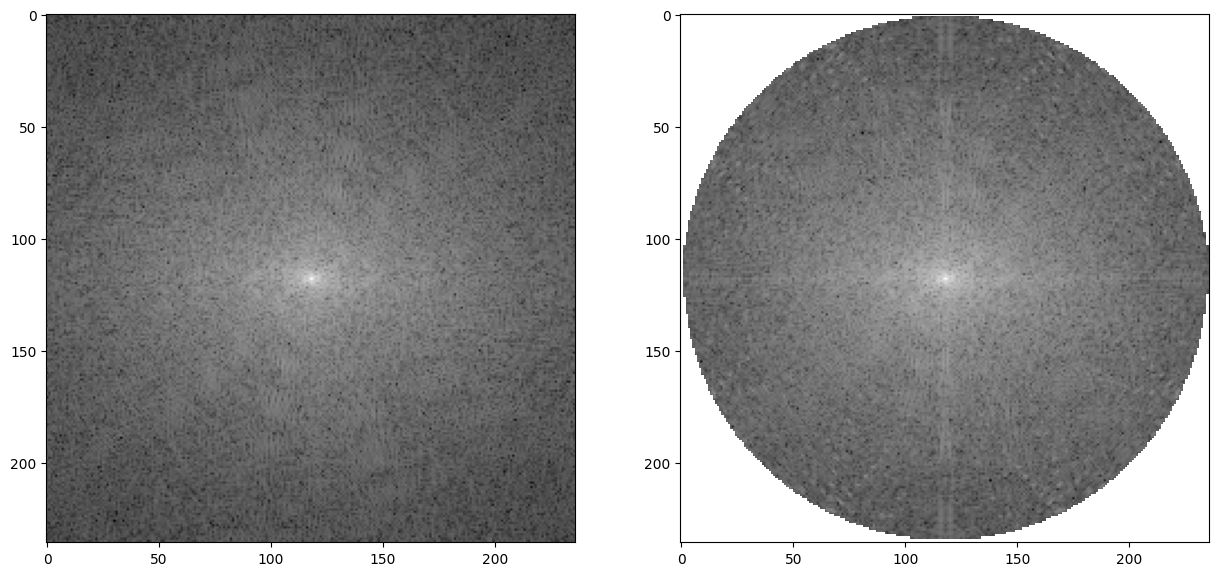

In [28]:
spec_mod = np.log(abs(res))
figure, axis = plt.subplots(1, 2, figsize=(15, 15)) # subplots let you visualize multiple outputs simultanously
axis[0].imshow(spec, cmap='gray')
axis[1].imshow(spec_mod, cmap='gray')

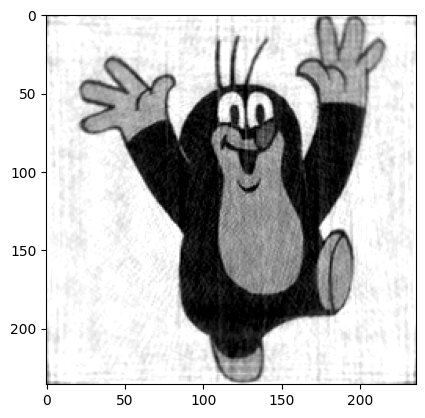

In [29]:
res2 = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(res))))

show_gray(res2)